# Multi task linear models
Estos modelos son utilizados cuando se requiere modelar la relacion de los datos de entrada con mas de un dato de salida.
Dos de ellos son: Multi-task Lasso regresion y Multi-task Elastic-Net

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [2]:
df = pd.read_excel('Viscosity MW.xlsx')

In [3]:
df.head()

,Viscosity,Temp,Stir,Time,MW
0,2750.0,147.0,57.0,170.0,3446.465952
1,2900.0,164.0,49.0,130.0,3574.074427
2,2630.0,141.0,47.0,160.0,3227.380306
3,2800.0,164.0,74.0,135.0,3477.028623
4,3000.0,132.0,65.0,150.0,3692.104936


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Viscosity  170 non-null    float64
 1   Temp       170 non-null    float64
 2   Stir       170 non-null    float64
 3   Time       170 non-null    float64
 4   MW         170 non-null    float64
dtypes: float64(5)
memory usage: 6.8 KB


In [5]:
df.describe()

,Viscosity,Temp,Stir,Time,MW
count,170.000000,170.000000,170.000000,170.000000,170.000000
mean,1828.411765,113.029412,98.352941,131.058824,2296.366323
std,883.228221,46.024900,42.975211,41.864491,1059.612832
min,254.000000,36.000000,28.200000,59.400000,388.867110
25%,1192.500000,78.000000,66.250000,96.800000,1544.479133
50%,1796.000000,106.000000,90.500000,127.000000,2237.224118
75%,2533.000000,144.100000,124.000000,161.750000,3139.112374
max,3877.000000,229.600000,214.200000,238.000000,4751.105398


In [6]:
X = df.drop(['Viscosity'], axis=1)

In [7]:
X = X.drop(['MW'], axis=1)

In [9]:
y = df[['Viscosity', 'MW']]
y.head()

,Viscosity,MW
0,2750.0,3446.465952
1,2900.0,3574.074427
2,2630.0,3227.380306
3,2800.0,3477.028623
4,3000.0,3692.104936


### Estandarizado de datos

In [10]:
from sklearn.preprocessing import StandardScaler
X1 = StandardScaler().fit_transform(X)

### Se convierten los datos en una matriz polinomial de grado 2

In [11]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False)
X2 = poly.fit_transform(X1)

In [12]:
# Separar en conjuntos de entrenamiento y testing
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size = 0.25, random_state=27)

In [13]:
# Define a function to get cross validation scores
def get_cv_scores(model):
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    print("CV Mean: ", np.mean(scores))
    print("STD: ", np.std(scores))
    print("\n")

In [14]:
from sklearn.linear_model import MultiTaskLasso

In [15]:
reg = MultiTaskLasso(max_iter=100000)
reg.fit(X_train, y_train)

MultiTaskLasso(max_iter=100000)

In [16]:
get_cv_scores(reg)
print('Train Score: ', reg.score(X_train, y_train))
print('Test Score: ', reg.score(X_test, y_test))

CV Mean:  0.7727844670222137
STD:  0.06994400576445185


Train Score:  0.8199776397694589
Test Score:  0.6231503931418352


In [20]:
# Find iptimal alpha with grid search
alpha = np.logspace(-4,4,9)
param_grid = dict(alpha=alpha)
grid = GridSearchCV(estimator=reg, param_grid=param_grid, scoring='r2', n_jobs=-1)
grid_result = grid.fit(X_train, y_train)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Best Score:  0.774080323534563
Best Params:  {'alpha': 0.0001}


In [28]:
# Ahora se ejecuta con los mejores parametros
reg = MultiTaskLasso(alpha=0.0001)
reg.fit(X_train, y_train)

MultiTaskLasso(alpha=0.0001)

In [29]:
get_cv_scores(reg)
print('Train Score: ', reg.score(X_train, y_train))
print('Test Score: ', reg.score(X_test, y_test))

CV Mean:  0.774080323534563
STD:  0.06934248395658801


Train Score:  0.8201625364790468
Test Score:  0.6173433807349122


In [30]:
reg.intercept_

array([1928.93791513, 2424.86970301])

In [31]:
coef = reg.coef_
coef

array([[ 404.65015242, -264.50715636,  531.60941176, -199.18273726,
        -161.45728461,  655.36295081,  -93.24028119,  278.02432962,
        -416.91425853],
       [ 485.9499356 , -318.96009704,  641.29754926, -243.57942818,
        -196.1485825 ,  793.14544695, -111.37782069,  334.22040534,
        -509.24678373]])

In [32]:
coef1 = coef[0,:]
coef1

array([ 404.65015242, -264.50715636,  531.60941176, -199.18273726,
       -161.45728461,  655.36295081,  -93.24028119,  278.02432962,
       -416.91425853])

In [33]:
coef2 = coef[1,:]
coef2

array([ 485.9499356 , -318.96009704,  641.29754926, -243.57942818,
       -196.1485825 ,  793.14544695, -111.37782069,  334.22040534,
       -509.24678373])

In [34]:
terms = ['Temp', 'Stir', 'Time', 'Temp*Temp','Temp*Stir', 'Temp*Time', 'Stir*Stir', 'Stir*Time', 'Time*Time']

In [35]:
for coef, term in enumerate(terms):
    print(f'{term}:{coef1[coef]}')

Temp:404.6501524233188
Stir:-264.5071563568094
Time:531.6094117565023
Temp*Temp:-199.18273726383734
Temp*Stir:-161.45728460657114
Temp*Time:655.3629508052393
Stir*Stir:-93.2402811928068
Stir*Time:278.0243296244155
Time*Time:-416.9142585271541


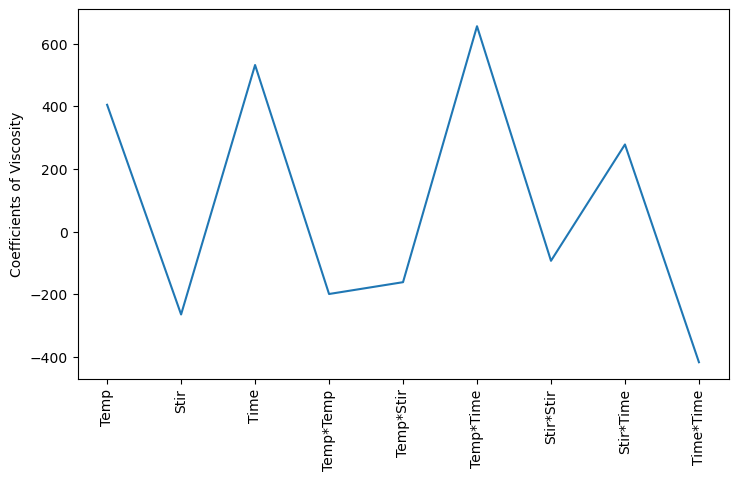

In [36]:
_ = plt.figure(figsize=[8.4,4.8])
_ = plt.plot(range(len(terms)), coef1)
_ = plt.xticks(range(len(terms)), terms, rotation=90)
_ = plt.ylabel('Coefficients of Viscosity')
plt.show()

In [37]:
for coef, term in enumerate(terms):
    print(f'{term}:{coef2[coef]}')

Temp:485.9499356010131
Stir:-318.9600970441689
Time:641.2975492577226
Temp*Temp:-243.5794281765584
Temp*Stir:-196.1485825042709
Temp*Time:793.1454469540184
Stir*Stir:-111.37782068756079
Stir*Time:334.2204053354204
Time*Time:-509.2467837334409


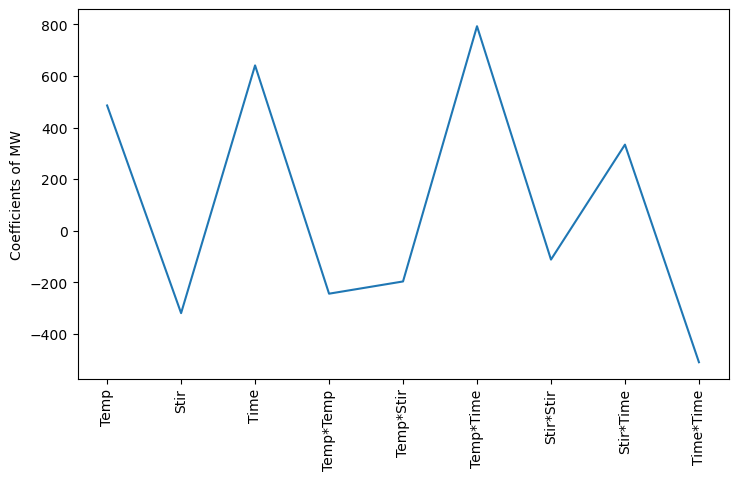

In [38]:
_ = plt.figure(figsize=[8.4,4.8])
_ = plt.plot(range(len(terms)), coef2)
_ = plt.xticks(range(len(terms)), terms, rotation=90)
_ = plt.ylabel('Coefficients of MW')
plt.show()

Para la regresion ElasticNet se hace de la misma manera que la Lasso, tomando en cuenta que ElasticNet cuenta con dos hyperparametros en lugar de uno. Consultar capitulo 5